# Example of usage Spark OCR for Cells Detection and Recognition

This notebook demonstrate pipeline for extract tabular data from image of the table.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.3.0.spark30.tar.gz

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [5]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [6]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.0.1")

spark

Spark version: 3.0.2
Spark OCR version: 3.4.0



## Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr/python/sparkocr/resources/ocr/tableImageDocument/0151_180.png_table_0.jpg
    Resolution: 0 dpi
    Width: 1471 px
    Height: 1654 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


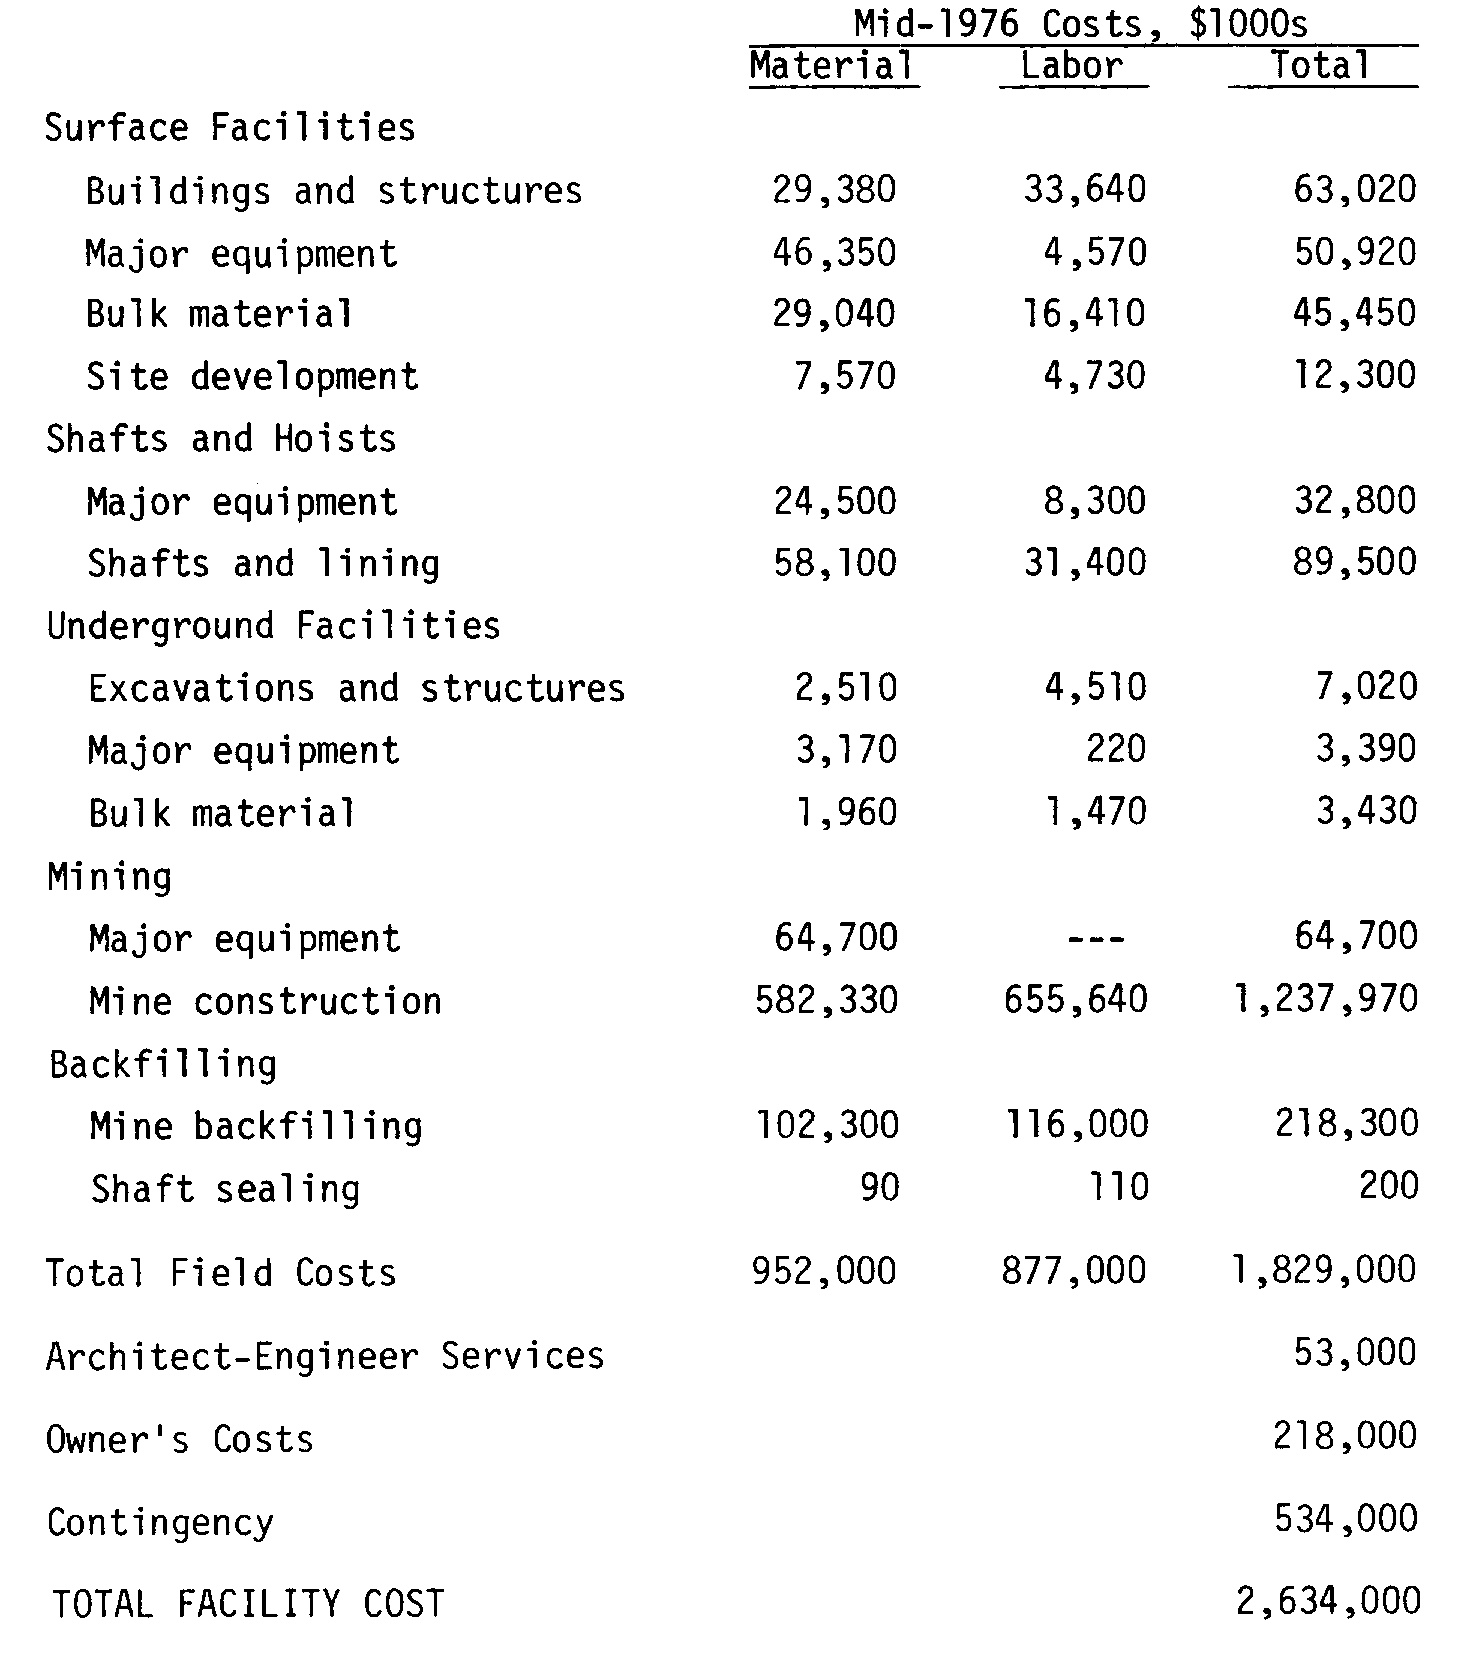

In [7]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/tableImageDocument/0151_180.png_table_0.jpg')
image_df= spark.read.format("binaryFile").load(test_image_path)

display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [8]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_BYTE_GRAY)
binary_to_image.setInputCol("content")

cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(2)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

pipeline = PipelineModel(stages=[
    binary_to_image,
     cell_detector,
     table_recognition
])

## Run pipeline

In [9]:
results = pipeline.transform(image_df).cache()

path_array = f.split(results['path'], '/')

exploded_results = results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .select("table", "filename") \
    .withColumn("cells", f.explode(f.col("table.chunks"))) \
    .select([f.col("filename")] + [f.col("cells")[i].getField("chunkText").alias(f"col{i}") for i in
                                   range(0, 4)])


## Show recognized cells for first image

In [10]:
exploded_results.show(20, False)

+------------------------+------------------------------------+------------+----------------+-----------+
|filename                |col0                                |col1        |col2            |col3       |
+------------------------+------------------------------------+------------+----------------+-----------+
|0151_180.png_table_0.jpg|                                    |Mid-Material|1976 Costs,Labor|$1000sTotal|
|0151_180.png_table_0.jpg|Surface Facilities                  |            |                |           |
|0151_180.png_table_0.jpg|Buildings and structures            |29,380      |33,640          |63,020     |
|0151_180.png_table_0.jpg|Major equipment                     |46 ,350     |4,570           |50,920     |
|0151_180.png_table_0.jpg|Bulk material                       |29,040      |16,410          |45,450     |
|0151_180.png_table_0.jpg|Site development                    |7,570       |4,730           |12,300     |
|0151_180.png_table_0.jpg|Shafts and Hoists   